# Exploring Dandiset 001366: Vessel Diameter and Pulsatility Quantification in Mouse Pial Vessels

> **Note**: This notebook was generated with AI assistance. Users should carefully verify all code and results before use in research.

## Overview
This Dandiset ([DANDI:001366](https://dandiarchive.org/dandiset/001366/0.250324.1603)) contains movies of pial vessels in mice, used to compare different methods for quantifying surface vessel diameter and pulsatility. The data includes high-frame-rate grayscale imaging of blood vessels through thinned skull preparations.

### This Notebook Covers:
1. Loading and examining NWB file metadata
2. Accessing and visualizing vessel imaging data
3. Extracting and analyzing vessel intensity traces
4. Template code for working with the dataset
5. Potential analysis pathways

### Required Packages
```python
dandi
pynwb
h5py
remfile
numpy
matplotlib
```

## Accessing the Dandiset

In [1]:
from dandi.dandiapi import DandiAPIClient
import remfile
import h5py
import pynwb
import numpy as np
import matplotlib.pyplot as plt

# Create DANDI API client
client = DandiAPIClient()
dandiset = client.get_dandiset("001366", "0.250324.1603")

# List available NWB files
assets = list(dandiset.get_assets_by_glob("*.nwb"))

# Display asset information
for asset in assets:
    print(f"File: {asset.path}")
    print(f"Size: {asset.size / 1e6:.2f} MB\n")

File: sub-F15/sub-F15_ses-F15BC-19102023_image.nwb
Size: 408.09 MB

File: sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb
Size: 2377.82 MB



## Loading and Examining NWB Files
Let's create a reusable function to load NWB files from DANDI:

In [2]:
def load_nwb_file(dandiset_id, version, asset_path):
    """
    Load an NWB file from DANDI archive
    
    Parameters:
    -----------
    dandiset_id : str
        DANDI identifier
    version : str
        Version of the dataset
    asset_path : str
        Path to the NWB file within the dataset
    
    Returns:
    --------
    nwbfile : pynwb.NWBFile
    movies : pynwb.ImageSeries
    asset : dandi asset object
    """
    client = DandiAPIClient()
    dandiset = client.get_dandiset(dandiset_id, version)
    asset = next(dandiset.get_assets_by_glob(asset_path))
    remote_file = remfile.File(asset.download_url)
    h5_file = h5py.File(remote_file)
    io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
    nwbfile = io.read()
    movies = nwbfile.acquisition['Movies']
    return nwbfile, movies, asset

Let's examine the first NWB file:

In [3]:
# Load the first NWB file
nwb_path = 'sub-F15/sub-F15_ses-F15BC-19102023_image.nwb'
nwbfile, movies, asset = load_nwb_file('001366', '0.250324.1603', nwb_path)

# Print key metadata
print("Session Description:", nwbfile.session_description)
print("\nSubject Information:")
print(f"ID: {nwbfile.subject.subject_id}")
print(f"Species: {nwbfile.subject.species}")
print(f"Sex: {nwbfile.subject.sex}")
print(f"Age: {nwbfile.subject.age}")
print(f"Strain: {nwbfile.subject.strain}")

print("\nMovie Information:")
print(f"Frame rate: {movies.rate} Hz")
print(f"Dimensions: {movies.data.shape}")
print(f"Data type: {movies.data.dtype}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Session Description: a wild-type mouse skull was thinned at the area of the middle cerebral artery (MCA) and fitted with a head plate for fixation.

Subject Information:
ID: F15
Species: Mus musculus
Sex: F
Age: P9W/P16W
Strain: C57BL/6J

Movie Information:
Frame rate: 54.47 Hz
Dimensions: (9553, 214, 132)
Data type: uint16


## Visualizing the Data
Let's examine sample frames from the vessel movie:

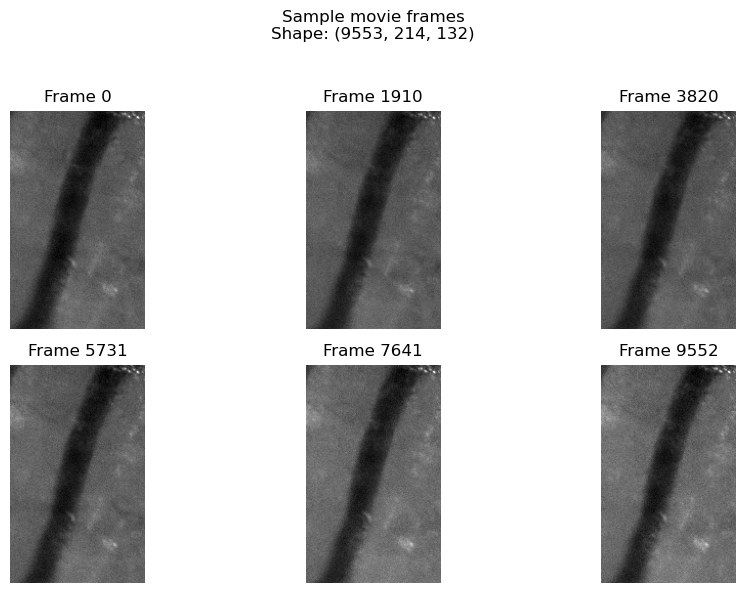

In [4]:
# Extract evenly spaced frames for visualization
example_indices = np.linspace(0, movies.data.shape[0]-1, 6, dtype=int)
frames = [movies.data[idx, :, :] for idx in example_indices]

# Create subplot grid
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

# Plot frames
for i, ax in enumerate(axes):
    ax.imshow(frames[i], cmap='gray')
    ax.set_title(f'Frame {example_indices[i]}')
    ax.axis('off')

fig.suptitle(f'Sample movie frames\nShape: {movies.data.shape}')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Analyzing Vessel Dynamics
Let's extract and plot an intensity trace along the vessel to visualize pulsatility:

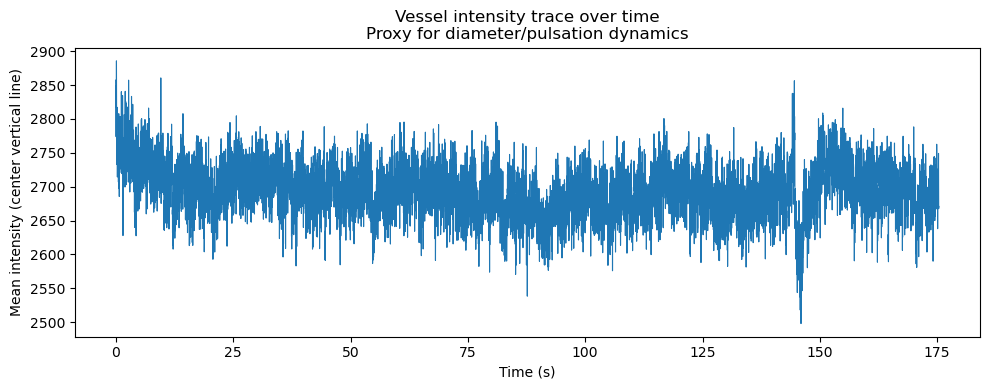

In [5]:
# Extract intensity trace from center of vessel
shape = movies.data.shape
column = shape[2] // 2  # Center column
rows = np.arange(shape[1]//2-3, shape[1]//2+3)  # 6-pixel band around center

# Calculate mean intensity across the band for each frame
line_trace = []
for frame_idx in range(shape[0]):
    frame = movies.data[frame_idx, :, :]
    profile = frame[rows, column]
    line_trace.append(np.mean(profile))
line_trace = np.array(line_trace)

# Create time vector
time = np.arange(shape[0]) / movies.rate

# Plot intensity trace
plt.figure(figsize=(10, 4))
plt.plot(time, line_trace, lw=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Mean intensity (center vertical line)')
plt.title('Vessel intensity trace over time\nProxy for diameter/pulsation dynamics')
plt.tight_layout()
plt.show()

## Potential Analyses
This dataset enables several types of analyses:
1. **Vessel Diameter Quantification**
   - Track vessel wall positions
   - Compare different measurement methods
2. **Pulsatility Analysis**
   - Extract physiological rhythms
   - Analyze pulse amplitude and waveforms
3. **Method Comparison**
   - Benchmark different vessel detection algorithms
   - Compare accuracy across conditions
4. **Cross-Subject Comparisons**
   - Compare vessel dynamics across subjects
   - Examine effects of age, sex, or preparation

## Best Practices for Analysis
1. Always check session and subject metadata
2. Use acquisition metadata (frame rate, dimensions) from NWB file
3. Load only necessary frames to optimize memory usage
4. Document analysis parameters and steps
5. Consider physiological and technical sources of variation